<a href="https://colab.research.google.com/github/ALIF-AL-RAZI/python-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Setup Kaggle import data

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download studymart/nlp-fake-news

Dataset URL: https://www.kaggle.com/datasets/studymart/nlp-fake-news
License(s): CC0-1.0


In [8]:
!unzip nlp-fake-news.zip

Archive:  nlp-fake-news.zip
  inflating: WELFake_Dataset.csv     


# Step 1: Import necessary libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
import string
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the dataset

In [10]:
df = pd.read_csv('/content/WELFake_Dataset.csv')

In [11]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [12]:
df.tail()

,Unnamed: 0,title,text,label
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [13]:
df['text'][0]

'No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to

In [14]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
df.isnull().sum()

,0
title,558
text,39
label,0


# Step 3: Handle null values and separate features from labels

In [17]:
df.fillna(' ', inplace=True)

In [18]:
features = df[['title', 'text']]
labels = df['label']

In [19]:
df.isnull().sum()

,0
title,0
text,0
label,0


In [20]:
label_Status = df['label'].value_counts()
label_Status.index = ['Real', 'Fake']
transactions = label_Status.index
quantity = label_Status.values

fig = px.pie(df, values=quantity, names=transactions, hole=0.5, title='Distribution of Transactions')
fig.show()

In [21]:
label_Status.index = ['Real', 'Fake']

# Step 4: Create word clouds

In [22]:
# prompt: code to visualise the words used in each classes

import plotly.express as px

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()




In [23]:
real_news = ' '.join(df[df['label'] == 1]['text'])
fake_news = ' '.join(df[df['label'] == 0]['text'])

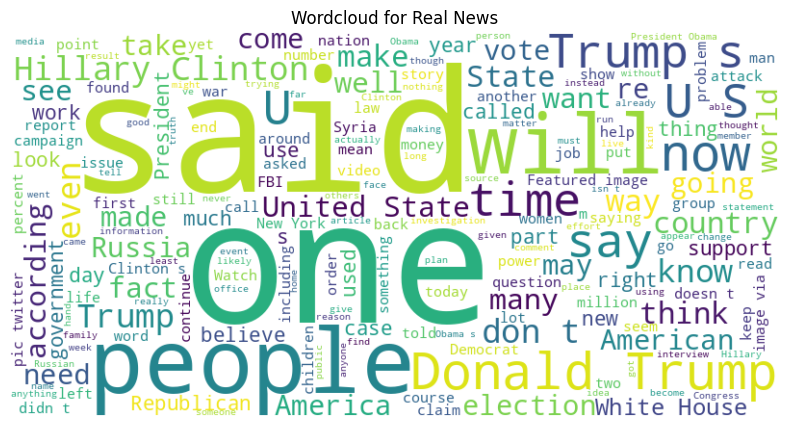

In [24]:
plot_wordcloud(real_news, 'Wordcloud for Real News')

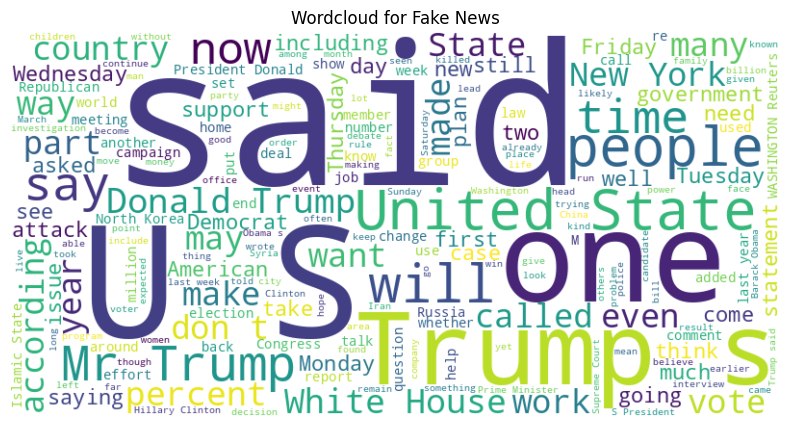

In [25]:
plot_wordcloud(fake_news, 'Wordcloud for Fake News')

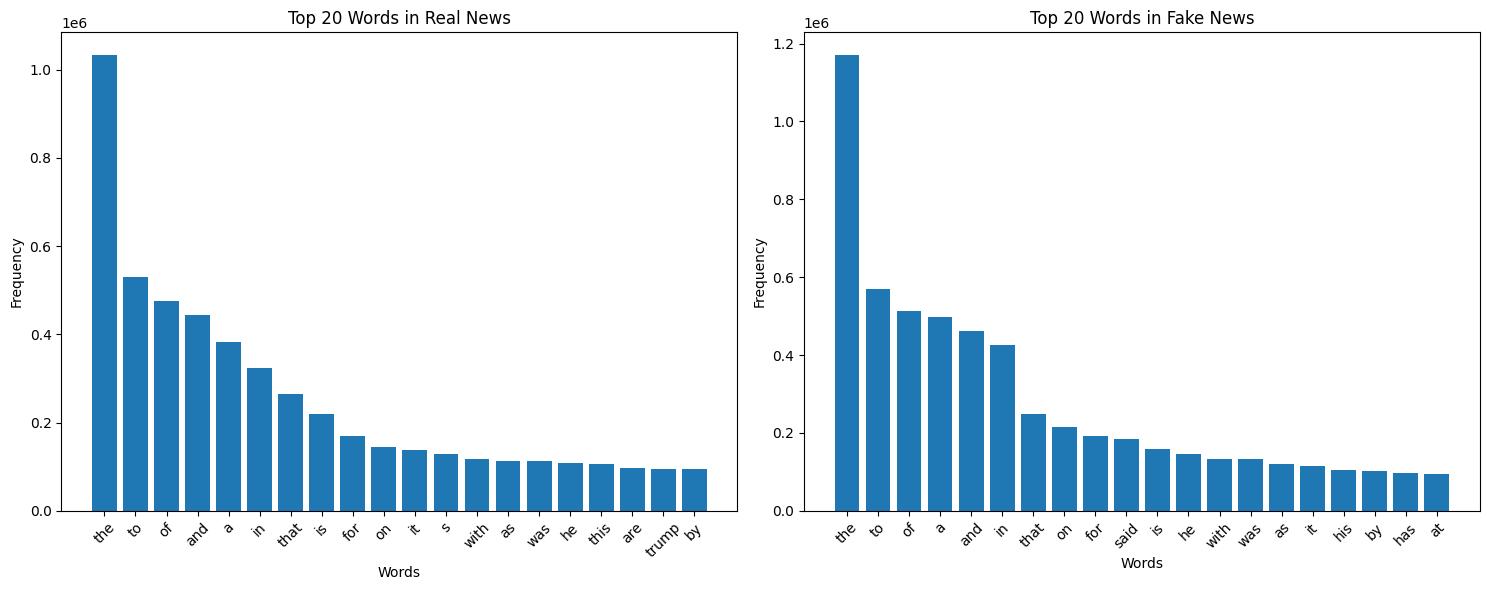

In [26]:
# prompt: code to visualise the words used in each classes by histogram

import matplotlib.pyplot as plt
from collections import Counter

def plot_word_histograms(df):
    """Plots histograms of word frequencies for each class."""

    # Separate text by label
    real_news_text = ' '.join(df[df['label'] == 1]['text']).lower()
    fake_news_text = ' '.join(df[df['label'] == 0]['text']).lower()

    # Remove punctuation and tokenize
    real_words = [word for word in real_news_text.translate(str.maketrans('', '', string.punctuation)).split() if word.isalpha()]
    fake_words = [word for word in fake_news_text.translate(str.maketrans('', '', string.punctuation)).split() if word.isalpha()]

    # Count word frequencies
    real_word_counts = Counter(real_words)
    fake_word_counts = Counter(fake_words)

    # Get top N frequent words (adjust N as needed)
    N = 20
    real_top_words = real_word_counts.most_common(N)
    fake_top_words = fake_word_counts.most_common(N)

    # Separate words and counts for plotting
    real_words, real_counts = zip(*real_top_words)
    fake_words, fake_counts = zip(*fake_top_words)


    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot histograms
    axes[0].bar(real_words, real_counts)
    axes[0].set_title('Top {} Words in Real News'.format(N))
    axes[0].set_xlabel('Words')
    axes[0].set_ylabel('Frequency')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axes[1].bar(fake_words, fake_counts)
    axes[1].set_title('Top {} Words in Fake News'.format(N))
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Frequency')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels


    plt.tight_layout()
    plt.show()

plot_word_histograms(df)


# Step 5: Text preprocessing

In [27]:
text_column = 'text'
label_column = 'label'

In [28]:
import nltk

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stopword = set(stopwords.words('english'))
stopword

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [31]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
import re

In [33]:
def preprocessText(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
    text = ([word for word in text.split() if word not in stopword]) #remove stopwords
    return text


In [34]:
df['text'] = df['text'].apply(preprocessText)

In [35]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Step 6: Lemmatization

In [36]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text])
    return lemmatized_text



In [37]:
df['text'] = df['text'].apply(lemmatize_text)

# Step 7: TF-IDF Vectorization

In [38]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Step 8: Split dataset into training and testing sets

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
from sklearn.metrics import precision_recall_curve, auc

# Step 09: Evaluate Naive Bayes models

In [41]:
def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    prob = model.predict_proba(xtest)[:, 1]
    roc_auc = roc_auc_score(ytest, prob)
    fpr, tpr, thresholds = roc_curve(ytest, prob)
    precision, recall, _ = precision_recall_curve(ytest, prob)
    pr_auc = auc(recall, precision)

    return {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds,
        'Precision': precision,
        'Recall': recall
    }

# Multinomial Naive Bayes

In [42]:
mnb_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
mnb_model.fit(xtrain, ytrain)

MultinomialNB()

In [43]:
nb_result = evaluate_model(mnb_model, xtest, ytest)

In [44]:
nb_result

{'Accuracy': 0.8756989048565224,
 'Confusion Matrix': array([[9678,  935],
        [1755, 9273]]),
 'ROC AUC': np.float64(0.948250140866173),
 'PR AUC': np.float64(0.9476237946940644),
 'FPR': array([0.        , 0.        , 0.        , ..., 0.9894469 , 0.98963535,
        1.        ]),
 'TPR': array([0.00000000e+00, 9.06782735e-05, 2.72034820e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'Thresholds': array([           inf, 9.99984186e-01, 9.99983121e-01, ...,
        3.69289217e-04, 3.67432142e-04, 2.84528217e-05]),
 'Precision': array([0.50958828, 0.50961183, 0.50963538, ..., 1.        , 1.        ,
        1.        ]),
 'Recall': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.81356547e-04, 9.06782735e-05, 0.00000000e+00])}

# Evaluate Manually

In [45]:
cm = confusion_matrix(ytest, mnb_model.predict(xtest))

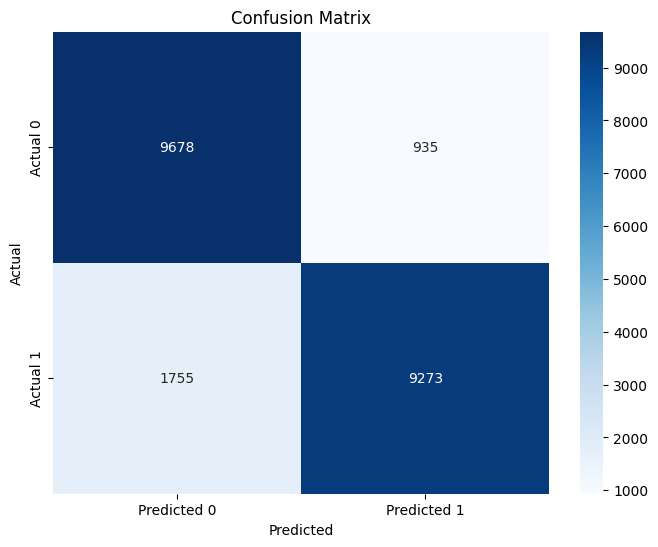

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
print(classification_report(ytest, mnb_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     10613
           1       0.91      0.84      0.87     11028

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



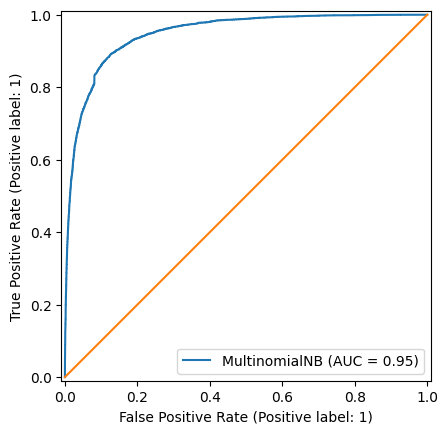

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Assuming 'mnb_model', 'xtest', and 'ytest' are defined

# Create an instance of RocCurveDisplay
roc_display = RocCurveDisplay.from_estimator(mnb_model, xtest, ytest)

# Plot the ROC curve

plt.plot([0, 1], [0, 1])  # Add diagonal line
plt.show()

# Step 9: Apply Logistic Regression

In [49]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(xtrain, ytrain)

LogisticRegression(max_iter=1000)

# Step 10: Evaluate Logistic Regression

In [63]:
lr_result = evaluate_model(lr_model, xtest, ytest)

In [64]:
lr_result

{'Accuracy': 0.9503719791137193,
 'Confusion Matrix': array([[ 9966,   647],
        [  427, 10601]]),
 'ROC AUC': np.float64(0.9895465286600248),
 'PR AUC': np.float64(0.9894567668310237),
 'FPR': array([0.        , 0.        , 0.        , ..., 0.99038915, 0.99038915,
        1.        ]),
 'TPR': array([0.00000000e+00, 9.06782735e-05, 1.45085238e-03, ...,
        9.99909322e-01, 1.00000000e+00, 1.00000000e+00]),
 'Thresholds': array([           inf, 9.99970949e-01, 9.99447333e-01, ...,
        8.44880516e-04, 8.42545321e-04, 2.37598178e-05]),
 'Precision': array([0.50958828, 0.50961183, 0.50963538, ..., 1.        , 1.        ,
        1.        ]),
 'Recall': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.81356547e-04, 9.06782735e-05, 0.00000000e+00])}

In [51]:
cm_lr = confusion_matrix(ytest, lr_model.predict(xtest))
cm_lr

array([[ 9966,   647],
       [  427, 10601]])

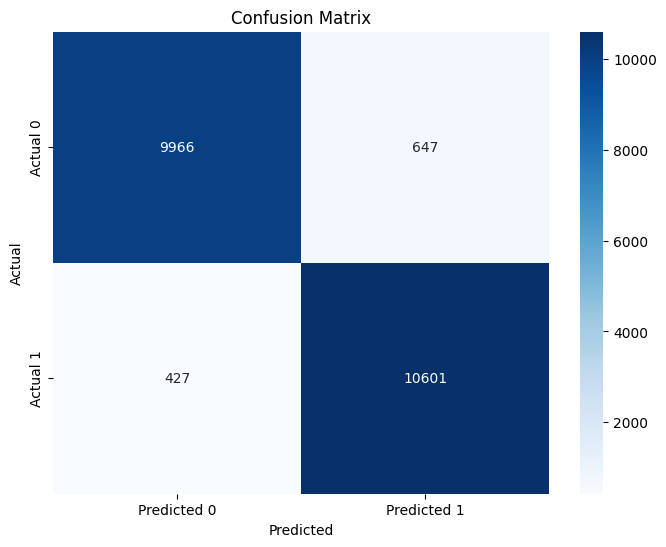

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

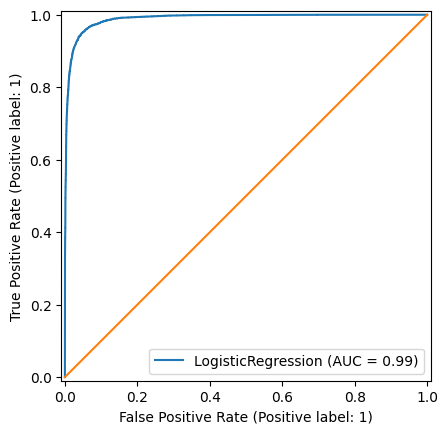

In [53]:
roc_display = RocCurveDisplay.from_estimator(lr_model, xtest, ytest)

# Plot the ROC curve

plt.plot([0, 1], [0, 1])  # Add diagonal line
plt.show()

# Step 11: Apply Logistic Bernoulli Naive Bayes

In [54]:
bnb_model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bnb_model.fit(xtrain, ytrain)

BernoulliNB()

# Step 12: Evaluate Bernoulli Naive Bayes

In [55]:
bnb_results = evaluate_model(bnb_model, xtest, ytest)
bnb_results

{'Accuracy': 0.8533339494478074,
 'Confusion Matrix': array([[8568, 2045],
        [1129, 9899]]),
 'ROC AUC': np.float64(0.9409552305480366),
 'PR AUC': np.float64(0.9521347865850108),
 'FPR': array([0.        , 0.00687836, 0.0070668 , ..., 0.99707905, 0.99707905,
        1.        ]),
 'TPR': array([0.        , 0.60826986, 0.60854189, ..., 0.99990932, 1.        ,
        1.        ]),
 'Thresholds': array([            inf, 1.00000000e+000, 1.00000000e+000, ...,
        1.17300370e-119, 1.67150052e-120, 3.06374925e-260]),
 'Precision': array([0.50958828, 0.50961183, 0.50963538, ..., 0.98894783, 0.98923463,
        1.        ]),
 'Recall': array([1.        , 1.        , 1.        , ..., 0.60854189, 0.60826986,
        0.        ])}

In [56]:
cm_bnb = confusion_matrix(ytest, bnb_model.predict(xtest))
cm_bnb

array([[8568, 2045],
       [1129, 9899]])

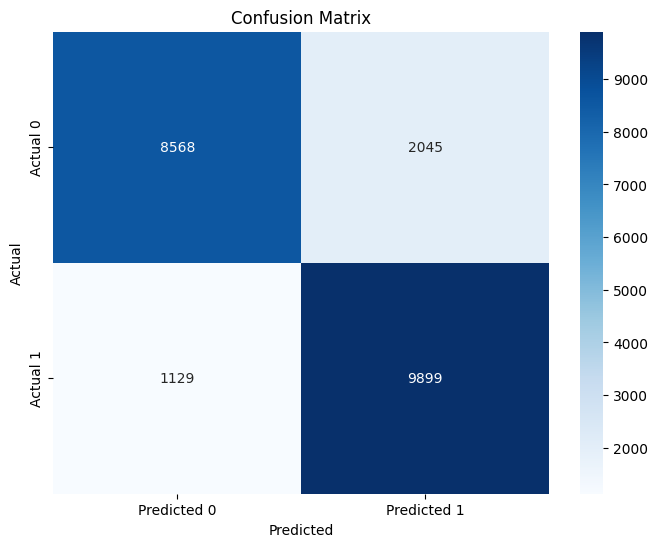

In [57]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
print(classification_report(ytest, bnb_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84     10613
           1       0.83      0.90      0.86     11028

    accuracy                           0.85     21641
   macro avg       0.86      0.85      0.85     21641
weighted avg       0.86      0.85      0.85     21641



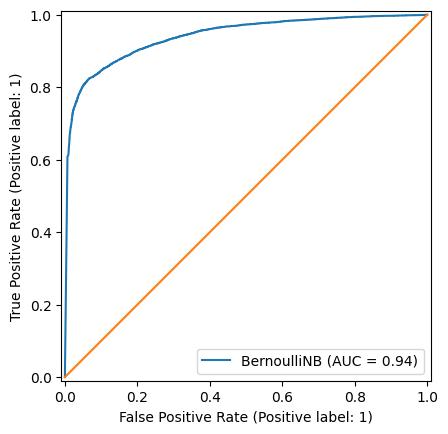

In [59]:
roc_display = RocCurveDisplay.from_estimator(bnb_model, xtest, ytest)

# Plot the ROC curve

plt.plot([0, 1], [0, 1])  # Add diagonal line
plt.show()

# Step 13: Visualize performance with histogram

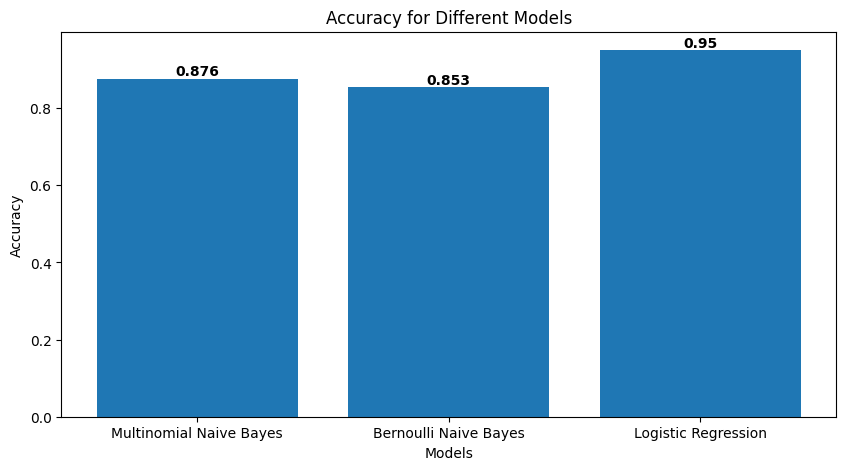

In [65]:
def plot_histogram(metric_values, model_names, metric_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = plt.bar(model_names, metric_values)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

    plt.show()

accuracy_values = [nb_result['Accuracy'], bnb_results['Accuracy'], lr_result['Accuracy']]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression']
plot_histogram(accuracy_values, model_names, 'Accuracy')


# Step 14: Input random text and make a prediction

In [66]:
models = [mnb_model, bnb_model, lr_model]

In [68]:
random_text = input()

preprocessed_text = preprocessText(random_text) # remove punctuation
lemmatized_text = lemmatize_text(preprocessed_text) # text scaling
text_vector = vectorizer.transform([lemmatized_text])

WASHINGTON (Reuters) - Hackers believed to be working for the Russian government broke into the Democratic National Committee’s computer network, spied on internal communications and accessed research on presumptive Republican presidential nominee Donald Trump, the committee and security experts said on Tuesday. Two separate groups entered the DNC’s system, and one read email and chat communications for nearly a year before being detected, according to the committee and CrowdStrike, the cyber firm that helped clean up the breach. Russian spies also targeted the networks of Trump and Democratic presidential candidate Hillary Clinton, as well as the computers of some Republican political action committees, the Washington Post quoted U.S. officials as saying, although details were not available. A Clinton campaign official said there was no evidence the campaign’s information systems had been hacked. A Russian government spokesman denied involvement in the breach. “I completely rule out a

In [70]:
preprocessed_text
lemmatized_text
text_vector
text_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [71]:
for model in models:
    prediction = model.predict(text_vector)
    print(f"Model: {type(model).__name__}")
    print("Prediction:", prediction)
    print('\n')

Model: MultinomialNB
Prediction: [0]


Model: BernoulliNB
Prediction: [0]


Model: LogisticRegression
Prediction: [0]




# **Step 16: Save Good ML Model for Deployment**

In [72]:
import pickle

# Define a file path where you want to save the model
model_file_path = 'logistic_regression_model.pkl'

# Save the model to the file
with open(model_file_path, 'wb') as model_file:
    pickle.dump(lr_model, model_file)


# **Load Model**



In [73]:
with open(model_file_path, 'rb') as model_file:
    loaded_LR = pickle.load(model_file)

In [74]:
loaded_LR.predict(xtest)

array([1, 1, 0, ..., 1, 1, 0])

In [75]:
loaded_LR.score(xtest, ytest)

0.9503719791137193

In [76]:
text_vector

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 297 stored elements and shape (1, 359771)>

In [77]:
loaded_LR.predict(text_vector)

array([0])